In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#Read file of joined Yelp Business & Review data
df = pd.read_csv('../Output_Folder/Santa_Barbara_Yelps.csv')
df.head(5)

,business_id,name,address,city,state,postal_code,review_count,review_id,stars,text
0,gebiRewfieSdtt17PTW6Zg,Hibachi Steak House & Sushi Bar,502 State St,Santa Barbara,CA,93101,488,pUycOfUwM8vqX7KjRRhUEA,3.0,Had a party of 6 here for hibachi. Our waitres...
1,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,389,L0jv8c2FbpWSlfNC6bbUEA,5.0,What a great addition to the Funk Zone! Grab ...
2,qO9dNNIvNbCBd8ZgjxMxgQ,HOME Santa Barbara,14 Parker Way,Santa Barbara,CA,93101,13,2u5Skti5mZam_-XTKPelvA,5.0,"Farmhouse, rustic, chic.Helpful staff with gre..."
3,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,2404,4zopEEPqfwm-c_FNpeHZYw,5.0,We were a bit weary about trying the Shellfish...
4,YbnJYHNp_fHbI-hcFg48vQ,Santa Barbara Adventure Company,32 E Haley St,Santa Barbara,CA,93101,195,HuWEnZr7-0HveaqXxyywgg,5.0,The kayaking tour at the Santa Cruz Island was...


Sentiment Analysis: https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

In [2]:
df = df[['text','stars']]
df.head()

,text,stars
0,Had a party of 6 here for hibachi. Our waitres...,3.0
1,What a great addition to the Funk Zone! Grab ...,5.0
2,"Farmhouse, rustic, chic.Helpful staff with gre...",5.0
3,We were a bit weary about trying the Shellfish...,5.0
4,The kayaking tour at the Santa Cruz Island was...,5.0


In [3]:
df.shape

(486, 2)

In [4]:
df=df.dropna()
df = df.reset_index(drop=True)
df.head()

,text,stars
0,Had a party of 6 here for hibachi. Our waitres...,3.0
1,What a great addition to the Funk Zone! Grab ...,5.0
2,"Farmhouse, rustic, chic.Helpful staff with gre...",5.0
3,We were a bit weary about trying the Shellfish...,5.0
4,The kayaking tour at the Santa Cruz Island was...,5.0


In [5]:
df.shape

(385, 2)

In [6]:
# Label the 4 & 5 star reviews as positive ('1') and 
# label the 1 & 2 star reviews as negative ('0'). 
# Drop the 3 star reviews as they are neutral

df['stars']=df['stars'].astype(int) #convert stars column to int

df=df[df['stars']!=3] #Drop 3-star reviews
df['label']=np.where(df['stars']>=4,1,0) #1-Positive, 0-Negative

df.head()

,text,stars,label
1,What a great addition to the Funk Zone! Grab ...,5,1
2,"Farmhouse, rustic, chic.Helpful staff with gre...",5,1
3,We were a bit weary about trying the Shellfish...,5,1
4,The kayaking tour at the Santa Cruz Island was...,5,1
5,The court house is very old and the art is gre...,4,1


In [7]:
df2 = df[['stars', 'label']]
df2.head()

,stars,label
1,5,1
2,5,1
3,5,1
4,5,1
5,4,1


In [8]:
# Get the number of reviews and group by star rating
df['stars'].value_counts()

5    210
4    100
1     19
2     17
Name: stars, dtype: int64

In [9]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle
data=df[df['label']==0][:2300]
data=data.append(df[df['label']==1][:10000])
data = data.reset_index(drop=True)
display(data['label'].value_counts())
data


1    310
0     36
Name: label, dtype: int64

,text,stars,label
0,"Well, to start the dining area is very very da...",1,0
1,"No appetizers on the lunch menu, only choices ...",2,0
2,Sushi eaters beware. My family and I just ate ...,2,0
3,Really need to get some outlets. I understand ...,1,0
4,Probably one of the WORST experiences I''ve ha...,1,0
...,...,...,...
341,"Absolutely LOVED this space. Beautiful spot, ...",5,1
342,This place has a northern California vibe. Rem...,5,1
343,"Nice people, good wine. We enjoyed it here! Af...",5,1
344,The most amazing place for a guilt free breakf...,5,1


Pre-Processing

In [10]:
# Convert all reviews into the lower case
data['pre_process'] = data['text'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))

In [11]:
# Perform the Contractions on the reviews text, eg 'it won't be' becomes 'it will not be'
def contractions(s):
 s = re.sub(r"won't", "will not",s)
 s = re.sub(r"would't", "would not",s)
 s = re.sub(r"could't", "could not",s)
 s = re.sub(r"\'d", " would",s)
 s = re.sub(r"can\'t", "can not",s)
 s = re.sub(r"n\'t", " not", s)
 s= re.sub(r"\'re", " are", s)
 s = re.sub(r"\'s", " is", s)
 s = re.sub(r"\'ll", " will", s)
 s = re.sub(r"\'t", " not", s)
 s = re.sub(r"\'ve", " have", s)
 s = re.sub(r"\'m", " am", s)
 return s
data['pre_process']=data['pre_process'].apply(lambda x:contractions(x))


In [12]:
# Remove non-alpha characters
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [13]:
# Remove the extra spaces between the words
data['pre_process']=data['pre_process'].apply(lambda x: re.sub(' +', ' ', x))


In [14]:
# Remove the stop words by using the NLTK package
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [15]:
# Perform lemmatization using the wordnet lemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [16]:
data

,text,stars,label,pre_process
0,"Well, to start the dining area is very very da...",1,0,well start dining area dark sat sushi bar tabl...
1,"No appetizers on the lunch menu, only choices ...",2,0,appetizer lunch menu choice noodle fried rice ...
2,Sushi eaters beware. My family and I just ate ...,2,0,sushi eater beware family ate family ordered c...
3,Really need to get some outlets. I understand ...,1,0,really need get outlet understand want people ...
4,Probably one of the WORST experiences I''ve ha...,1,0,probably one worst experience restaurant let s...
...,...,...,...,...
341,"Absolutely LOVED this space. Beautiful spot, ...",5,1,absolutely loved space beautiful spot great fr...
342,This place has a northern California vibe. Rem...,5,1,place northern california vibe reminds brewery...
343,"Nice people, good wine. We enjoyed it here! Af...",5,1,nice people good wine enjoyed enjoying trip sb...
344,The most amazing place for a guilt free breakf...,5,1,amazing place guilt free breakfast delicious s...


In [17]:
post_process = data['pre_process']

print(post_process)

0      well start dining area dark sat sushi bar tabl...
1      appetizer lunch menu choice noodle fried rice ...
2      sushi eater beware family ate family ordered c...
3      really need get outlet understand want people ...
4      probably one worst experience restaurant let s...
                             ...                        
341    absolutely loved space beautiful spot great fr...
342    place northern california vibe reminds brewery...
343    nice people good wine enjoyed enjoying trip sb...
344    amazing place guilt free breakfast delicious s...
345    dog friendly good selection food drink cute ou...
Name: pre_process, Length: 346, dtype: object


In [18]:
data.to_csv('../Output_folder/pre_process.csv')
#df2.to_csv('Naive_data.csv', index=False)

In [19]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 

# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(post_process).toarray()

word_count_vector.shape

(346, 3518)

In [20]:
word_count_vector

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [21]:
rough_naive_data = [word_count_vector, df2]

rough_naive_data

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
      stars  label
 1        5      1
 2        5      1
 3        5      1
 4        5      1
 5        4      1
 ..     ...    ...
 378      1      0
 380      5      1
 381      4      1
 382      5      1
 384      2      0
 
 [346 rows x 2 columns]]

In [22]:
df2['word_count_vector'] = word_count_vector.tolist()

df2

,stars,label,word_count_vector
1,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,4,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
378,1,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
380,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
381,4,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
382,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [23]:
df2.to_csv('Naive_data.csv', index=False)

In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train, Y_test = train_test_split(data['pre_process'], data['label'], test_size=0.25, random_state=30)
print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

Train:  (259,) (259,) Test:  ((87,), (87,))


In [25]:
print("TFIDF Vectorizer……")
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

TFIDF Vectorizer……


In [26]:
# Implementing SVM with sklearn for classification
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)

In [27]:
# Fitting the Training data into model
clf.fit(tf_x_train,Y_train)

LinearSVC(random_state=0)

In [28]:
# Predicting the Test data
y_test_pred=clf.predict(tf_x_test)

<AxesSubplot:>

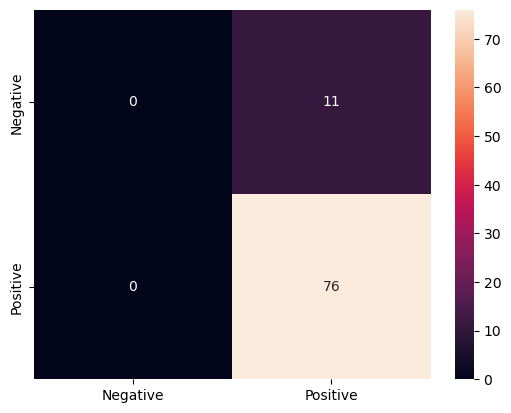

In [29]:
from sklearn import metrics
import seaborn as sns
#pred = voting.predict(x_test_tfidf)
cm=metrics.confusion_matrix(Y_test, y_test_pred)
cm = pd.DataFrame(cm, index = ["Negative", "Positive"], columns=["Negative", "Positive"])
sns.heatmap(cm, annot = True)
#plt.title("Confusion Matrix for Reviews Classifier")

In [30]:
# Analyzing the results
from sklearn.metrics import classification_report
report=classification_report(Y_test, y_test_pred,output_dict=True)
report

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 '1': {'precision': 0.8735632183908046,
  'recall': 1.0,
  'f1-score': 0.9325153374233129,
  'support': 76},
 'accuracy': 0.8735632183908046,
 'macro avg': {'precision': 0.4367816091954023,
  'recall': 0.5,
  'f1-score': 0.46625766871165647,
  'support': 87},
 'weighted avg': {'precision': 0.7631126965253006,
  'recall': 0.8735632183908046,
  'f1-score': 0.8146110993582963,
  'support': 87}}

By using the SVM Classifier we got an accuracy of 94.43%

In [31]:
# Logistic Regression is implemented using sklearn
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000, solver='saga')

In [32]:
# Fit the training data to the model
clf.fit(tf_x_train, Y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [33]:
# Predicting the test data
y_test_pred=clf.predict(tf_x_test)

In [34]:
# Analyzing the report
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_test_pred, output_dict=True)
report

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 '1': {'precision': 0.8735632183908046,
  'recall': 1.0,
  'f1-score': 0.9325153374233129,
  'support': 76},
 'accuracy': 0.8735632183908046,
 'macro avg': {'precision': 0.4367816091954023,
  'recall': 0.5,
  'f1-score': 0.46625766871165647,
  'support': 87},
 'weighted avg': {'precision': 0.7631126965253006,
  'recall': 0.8735632183908046,
  'f1-score': 0.8146110993582963,
  'support': 87}}

By using the LR classifier we got an accuracy of 92.20%

In [35]:
#the first is random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rmfr = RandomForestClassifier()
rmfr.fit(tf_x_train,Y_train)
predrmfr = rmfr.predict(tf_x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(Y_test,predrmfr))
print("Score:",round(accuracy_score(Y_test,predrmfr)*100,2))
print("Classification Report:\n",classification_report(Y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 0 11]
 [ 0 76]]
Score: 87.36
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.87      1.00      0.93        76

    accuracy                           0.87        87
   macro avg       0.44      0.50      0.47        87
weighted avg       0.76      0.87      0.81        87



C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(tf_x_train,Y_train)
preddt = dt.predict(tf_x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(Y_test,preddt))
print("Score:",round(accuracy_score(Y_test,preddt)*100,2))
print("Classification Report:\n",classification_report(Y_test,preddt))

Confusion Matrix for Decision Tree:
[[ 3  8]
 [ 7 69]]
Score: 82.76
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.27      0.29        11
           1       0.90      0.91      0.90        76

    accuracy                           0.83        87
   macro avg       0.60      0.59      0.59        87
weighted avg       0.82      0.83      0.82        87



In [37]:
#support vector machines
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(tf_x_train,Y_train)
predsvm = svm.predict(tf_x_test)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(Y_test,predsvm))
print("Score:",round(accuracy_score(Y_test,predsvm)*100,2))
print("Classification Report:\n",classification_report(Y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[ 0 11]
 [ 0 76]]
Score: 87.36
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.87      1.00      0.93        76

    accuracy                           0.87        87
   macro avg       0.44      0.50      0.47        87
weighted avg       0.76      0.87      0.81        87



C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
#count = CountVectorizer()

#idf_x_test = vectorizer.fit_transform(tf_x_test).toarray()

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])



#inverse document frequency
df_idf.sort_values(by=["idf_weights"])

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
place,1.922071
great,1.989512
good,2.195364
food,2.295448
would,2.360688
...,...
inspected,6.156178
inspired,6.156178
installed,6.156178
initial,6.156178


In [39]:
# count matrix 
count_vector=cv.transform(post_process) 

# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [40]:
feature_names = cv.get_feature_names() 

#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 

#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
bare,0.384173
hand,0.347236
tuna,0.269153
spicy,0.212803
roll,0.193825
...,...
forward,0.000000
four,0.000000
frame,0.000000
francisco,0.000000


In [41]:
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True) 

# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(post_process)

In [42]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] 

# place tf-idf values in a pandas data frame 
post_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
post_df.sort_values(by=["tfidf"],ascending=False)

C:\Users\david\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
bare,0.384173
hand,0.347236
tuna,0.269153
spicy,0.212803
roll,0.193825
...,...
forward,0.000000
four,0.000000
frame,0.000000
francisco,0.000000


In [43]:
#from sklearn.feature_extraction.text import TfidfVectorizer
text_string = [' '.join(data['pre_process'])]
text_string

['well start dining area dark sat sushi bar table dirty sticky next ordered got spicy tuna hand roll look chef making sushi see scooping spicy tuna bare hand packing seaweed wrap see walk microwave oven touch bare hand touch dirty menu bare hand go back spicy tuna roll continue scoop pack bare hand eat served since starving ordered another roll ate bad idea immediately became dizzy nauseous drank lot water decided maybe could walk left continued walk around downtown santa barbara longer minute left stomach started grumble felt faint running around frantically looking restroom finally found one puked sushi ate would reccomend eating inspected appetizer lunch menu choice noodle fried rice curry bottled water iced tea soda thai drink food bit bland positive vegetarian dish best mix vegetable vegetarian curry parking street front would come sushi eater beware family ate family ordered cooked item menu fine hand ordered sushi bento box sushi made incredibly ill taste bad fact got sick made 

In [44]:
from wordcloud import STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud
import re

d = {}
for a, x in post_df.values:
    d[a] = x

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
#text_string = re.sub('[^a-zA-Z]', '', str(text_string))
#print(text_string)

#text = post_df.loc['tfidf'].sort_values(ascending=False)
#text_todict = post_df.loc

#letterjumble = WordCloud(min_word_length=4, background_color='white')
#letterjumble.generate_from_frequencies(frequencies=text)

#stop_words = ["went", "really", "go", "going", "place", "day", "night", "one", "alway", "say", "make", "review", "got", "took", "around", "much", "came"] + list(STOPWORDS)
#graphic_df = WordCloud(stopwords = stop_words, min_word_length =4, background_color='white').generate(data['text'].to_string())

ValueError: not enough values to unpack (expected 2, got 1)

In [45]:
from wordcloud import STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud
import re

#text_string = re.sub('[^a-zA-Z]', '', str(text_string))
#print(text_string)

stop_words = ["went", "really", "go", "going", "place", "day", "night", "one", "alway", "say", "make", "review", "got", "took", "around", "much", "came"] + list(STOPWORDS)
text = WordCloud(stopwords = stop_words, min_word_length =4, background_color='white').generate(data['pre_process'].to_string())

Create a Word Cloud https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f; https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

(-0.5, 399.5, 199.5, -0.5)

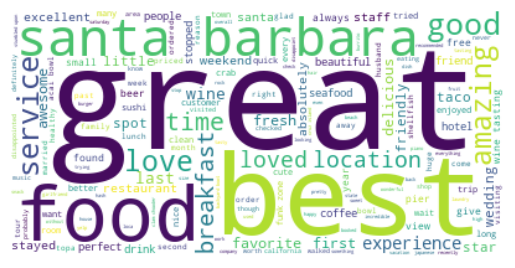

In [46]:

plt.imshow(text, interpolation='bilinear')
plt.axis("off")

In [47]:
# neg_reviews = data.loc[data['pre_process']]---- value 0, 
# pos_reviews = and another one for value 1

In [48]:
pos_reviews = data.loc[(data['label'] >= 1)]
pos_reviews.head()

,text,stars,label,pre_process
36,I haven't had a haircut in ages due to a bad e...,5,1,haircut age due bad experience salon marceline...
37,Last night we had a fabulous dinner! The food ...,5,1,last night fabulous dinner food authentic wond...
38,"Had the rock crab, oysters, and sea urchin. Ev...",4,1,rock crab oyster sea urchin every dish tasted ...
39,"Bomb. I go for the island bowl, always. \n\nF...",5,1,bomb go island bowl always health dr steve bruhle
40,GREAT WINES & AMAZING VIEWS! \n\nProbably the ...,5,1,great wine amazing view probably best view tas...


In [49]:
neg_reviews = data.loc[(data['label'] == 0)]
neg_reviews.head()

,text,stars,label,pre_process
0,"Well, to start the dining area is very very da...",1,0,well start dining area dark sat sushi bar tabl...
1,"No appetizers on the lunch menu, only choices ...",2,0,appetizer lunch menu choice noodle fried rice ...
2,Sushi eaters beware. My family and I just ate ...,2,0,sushi eater beware family ate family ordered c...
3,Really need to get some outlets. I understand ...,1,0,really need get outlet understand want people ...
4,Probably one of the WORST experiences I''ve ha...,1,0,probably one worst experience restaurant let s...


In [50]:
pos_text_string = [' '.join(pos_reviews['pre_process'])]
pos_text_string

['haircut age due bad experience salon marceline finally got decided try angela blue today long wavy hair cut perfectly made look much healthier everyone really nice atmosphere cozy overall great experience last night fabulous dinner food authentic wonderful restaurant extremely special waitstaff could sweeter attentive yoichi gem rock crab oyster sea urchin every dish tasted like heaven beer ice cold staff nice pup joined u sitting outside enjoyed smidge crab love place bomb go island bowl always health dr steve bruhle great wine amazing view probably best view tasting room world beat room end pier near degree ocean view seriously wine superb pinot rose particularly great lot great one charging premium location price surprisingly reasonable yup joined go place gem favorite spot funk zone hang especially sunday afternoon sip glass wine try beer sampler whatever mood unlike wine tasting spot around chilly day warm cozy fireplace relax lounge area warm day people watch wraparound porch f

In [51]:
pd.options.display.max_colwidth = 10000 #Changes the number of characters in a cell so that the contents don't get truncated (default is 50)

L = pos_text_string

#create new df 
pos_df = pd.DataFrame({'col':pos_text_string})
print (pos_df)

(-0.5, 399.5, 199.5, -0.5)

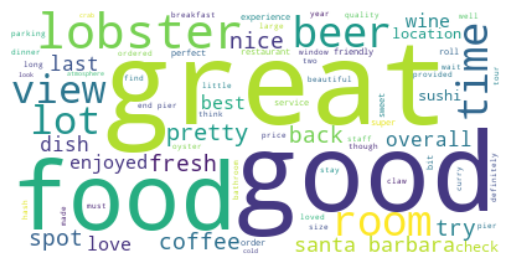

In [52]:

stop_words = ["went", "really", "go", "going", "place", "day", "night", "one", "alway", "say", "make", "review", "got", "took", "around", "much", "came"] + list(STOPWORDS)
text = WordCloud(max_words=75, stopwords = stop_words, min_word_length =3, background_color='white').generate(pos_df['col'].to_string())
plt.imshow(text, interpolation='bilinear')
plt.axis("off")


In [53]:
neg_text_string = [' '.join(neg_reviews['pre_process'])]
neg_text_string

['well start dining area dark sat sushi bar table dirty sticky next ordered got spicy tuna hand roll look chef making sushi see scooping spicy tuna bare hand packing seaweed wrap see walk microwave oven touch bare hand touch dirty menu bare hand go back spicy tuna roll continue scoop pack bare hand eat served since starving ordered another roll ate bad idea immediately became dizzy nauseous drank lot water decided maybe could walk left continued walk around downtown santa barbara longer minute left stomach started grumble felt faint running around frantically looking restroom finally found one puked sushi ate would reccomend eating inspected appetizer lunch menu choice noodle fried rice curry bottled water iced tea soda thai drink food bit bland positive vegetarian dish best mix vegetable vegetarian curry parking street front would come sushi eater beware family ate family ordered cooked item menu fine hand ordered sushi bento box sushi made incredibly ill taste bad fact got sick made 

In [54]:
pd.options.display.max_colwidth = 10000 #Changes the number of characters in a cell so that the contents don't get truncated (default is 50)

N = neg_text_string

#create new df 
neg_df = pd.DataFrame({'col':neg_text_string})
neg_df

col
0  well start dining area dark sat sushi bar table dirty sticky next ordered got spicy tuna hand roll look chef making sushi see scooping spicy tuna bare hand packing seaweed wrap see walk microwave oven touch bare hand touch dirty menu bare hand go back spicy tuna roll continue scoop pack bare hand eat served since starving ordered another roll ate bad idea immediately became dizzy nauseous drank lot water decided maybe could walk left continued walk around downtown santa barbara longer minute left stomach started grumble felt faint running around frantically looking restroom finally found one puked sushi ate would reccomend eating inspected appetizer lunch menu choice noodle fried rice curry bottled water iced tea soda thai drink food bit bland positive vegetarian dish best mix vegetable vegetarian curry parking street front would come sushi eater beware family ate family ordered cooked item menu fine hand ordered sushi bento box sushi made incredibly ill taste bad fact got sick made star experience new sushi frequently get sashimi restaurant time however stomach killing come restaurant make sure get cooked food really need get outlet understand want people sitting long really inconvenient need work computer option charge computer honestly reason stopped going also really need get shade pull window afternoon sun blind indoor searing unless wall probably one worst experience restaurant let start saying food good nothing wrong food chef amazing enjoyed food problem service made reservation ended getting around told needed wait enough chef totally fine understandable woman front seat party another party asked able sit group time told smaller group okay well reservation first sit care chef ready wanted sit order drink appetizer seated server ivan came promptly nice got first round drink thing went hill ordered sushi simple sushi salmon shrimp ordered roll crunch roll shrimp tempura roll brought yellowtail tuna veggie roll kindly said food ordered told wrong asked see sushi paper maybe marked wrong thing said threw paper away took sushi away huge attitude said would go try find paper well group could see back area pulled paper apron came said oh yeah guess fault brought guy wrong stuff okay tried explaining stuff finally come tasted perfect u ordered teppan got miso soup done got salad none u fork pretty sure maybe u knew use chopstick asked fork said yeah problem well waited minute saw find server ask help ended eating finger finally see ivan asked fork said honestly need right food cooked excuse furious would even come back attitude girl needed fork told yes need almost got go find anyways chef come food turned good ivan found minute girl group asked box included took minute get ended eating last bit food going take home brought box said sorry need box anymore finished going take home thank politely came back ok well maybe take plate away stop changing mind hell point done trying nice half hour glad leaving ivan rude girl group hope go back probably ivan always try give people benefit doubt maybe bad day day bad come work mean rude customer work public believe hard always please everyone unacceptable rude people worth knew bad feeling second walked restaurant bit hot sushi bar fish sitting behind unrefrigerated glass day listened gut made huge mistake ended getting sick worst sushi ever horrible service le star quality food overrated visited week many thing broken shower toilet cleanliness marginal management attitude like favor strong sale pitch muy mal servicio robaron ordene un pastel para persona dieron uno para persona muy mal sabor mal decorado tenga cuidado con sus ordenes disappointed place normally find place near water fresh albeit simple delicious seafood unfortunately case shanty sea price super inflated seafood fresh first major indicator group dine elsewhere ordered crab cake arrived lukewarm greasy overall appetizing think next time skip pier go straight fresh clambake im frequent backyard bowl customer usual

(-0.5, 399.5, 199.5, -0.5)

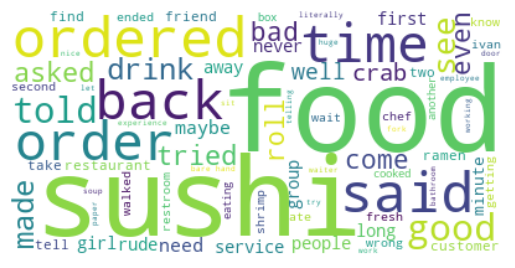

In [55]:
stop_words = ["went", "really", "go", "going", "place", "day", "night", "one", "alway", "say", "make", "review", "got", "took", "around", "much", "came"] + list(STOPWORDS)
text = WordCloud(max_words=75, stopwords = stop_words, min_word_length =3, background_color='white').generate(neg_df['col'].to_string())
plt.imshow(text, interpolation='bilinear')
plt.figure
plt.axis("off")

In [56]:
neg_df['col'].value_counts()

well start dining area dark sat sushi bar table dirty sticky next ordered got spicy tuna hand roll look chef making sushi see scooping spicy tuna bare hand packing seaweed wrap see walk microwave oven touch bare hand touch dirty menu bare hand go back spicy tuna roll continue scoop pack bare hand eat served since starving ordered another roll ate bad idea immediately became dizzy nauseous drank lot water decided maybe could walk left continued walk around downtown santa barbara longer minute left stomach started grumble felt faint running around frantically looking restroom finally found one puked sushi ate would reccomend eating inspected appetizer lunch menu choice noodle fried rice curry bottled water iced tea soda thai drink food bit bland positive vegetarian dish best mix vegetable vegetarian curry parking street front would come sushi eater beware family ate family ordered cooked item menu fine hand ordered sushi bento box sushi made incredibly ill taste bad fact got sick made st

In [57]:
# https://stackoverflow.com/questions/38465478/wordcloud-from-data-frame-with-frequency-python
# https://stackoverflow.com/questions/57826063/how-to-create-a-wordcloud-according-to-frequencies-in-a-pandas-dataframe
# Looking up how to create a wordcloud based on word frequency
d = {}
for a, x in neg_df.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# Look at an article to figure out word frequency: https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

# create a dictionary of word frequencies
text = ' '.join(neg_text_string) # create string out of a list
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True).generate(text)
text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
# 
#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:5])
print(list(rel_freq.items())[:5])

plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()